In [1]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import merge
from pwc_on_raw import warped_raw
import time

In [2]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [3]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]

## scene visualization: hand and bunny move against the background board

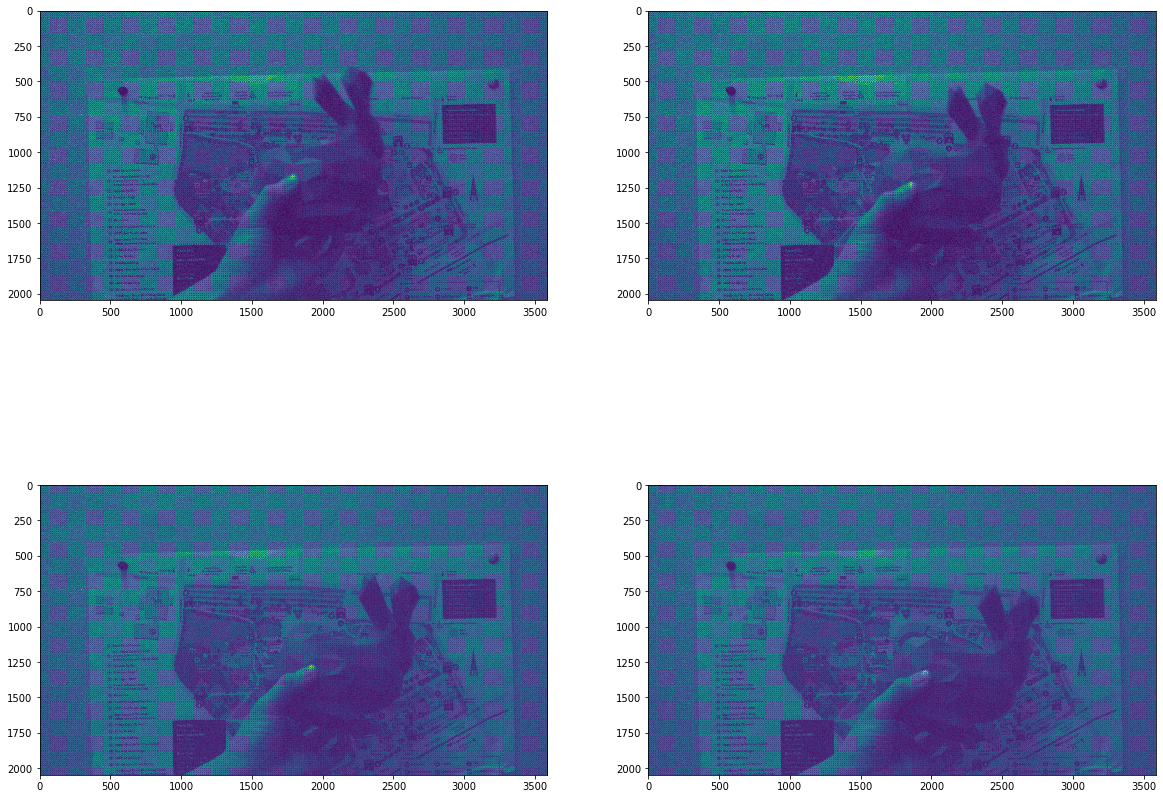

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(rIm[0])
ax[0][1].imshow(rIm[5])
ax[1][0].imshow(rIm[10])
ax[1][1].imshow(rIm[15])
plt.show()

## single raw frame

In [5]:
ref_idx = 0
rIm_single = rIm[ref_idx] - bk_lvl
rIm_single = np.clip(rIm_single, 0, 1023)
print_stat("rIm_single",rIm_single)
bit_length = np.log2(rIm_single.max())
print("bit_length", bit_length)

rIm_single  shape:  (2048, 3584) dtype: int16
rIm_single stat: max: 27, min: 0, mean: 6.548732621329171, std: 3.5766085926180717
bit_length 4.7548876


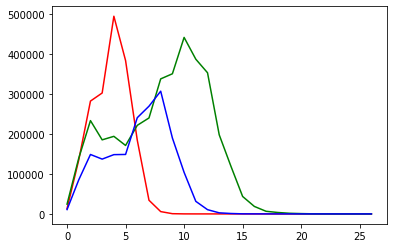

In [6]:
plot_histogram(rIm_single, bit_length)

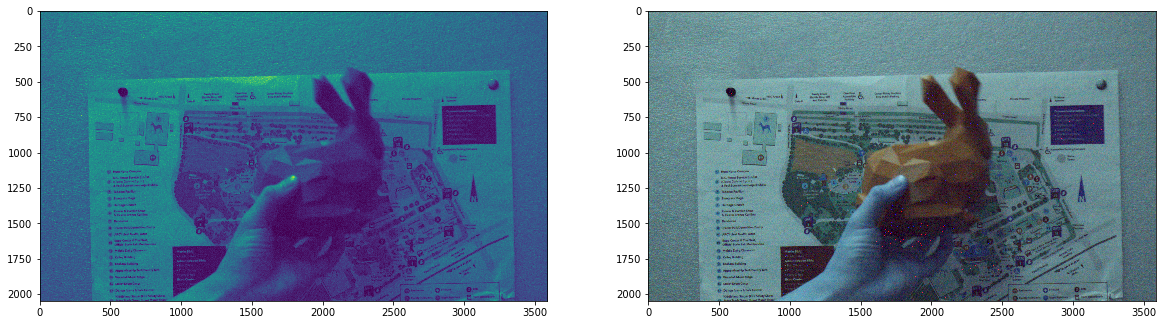

In [7]:
rgbIm_single = demosaic(rIm_single)
rgbIm_adj_single = adjustColor(rgbIm_single,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_single)
ax[1].imshow(rgbIm_adj_single)
plt.show()

## simple summation all frames

In [8]:
rIm_sum = rIm.sum(axis = 0) - bk_lvl* rIm.shape[0]
print_stat("rIm_sum", rIm_sum)
bit_length = np.log2(rIm_sum.max())
print("bit_length", bit_length)

rIm_sum  shape:  (2048, 3584) dtype: int64
rIm_sum stat: max: 425, min: 2, mean: 105.40667057037354, std: 54.342939102707916
bit_length 8.731319031025064


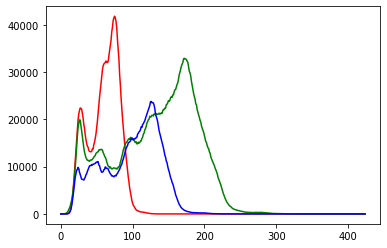

In [9]:
plot_histogram(rIm_sum, bit_length)

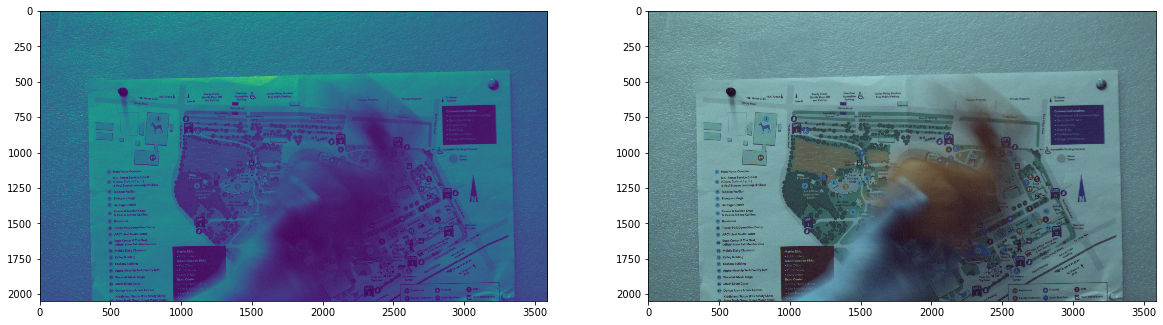

In [10]:
rIm_sum = np.clip(rIm_sum, 0, 1023)
rgbIm = demosaic(rIm_sum)
rgbIm_adj = adjustColor(rgbIm,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_sum)
ax[1].imshow(rgbIm_adj)
plt.show()

## flow pre-warping and merge

In [11]:
# merge_util: dist set 1420.4
start = time.time()
final = rIm[ref_idx].copy().astype(np.float64)
for idx in range(1, 16):
#     print("merge {}th raw frame...".format(idx))
    ref = rIm[ref_idx]
    _, alt = warped_raw(ref, rIm[idx], display = False) #np.load("warped_npys_lowlight3_bunny3/warped_{}.npy".format(idx))
    H, W = ref.shape
    bi_align_field = np.zeros((H//16-1, W//16-1, 2), dtype=ref.dtype) # zero since warped frames are aligned
    merged_frame = merge(ref, alt, bi_align_field)
    final += merged_frame
print("elapsed time: {:.2f}".format(time.time() - start))

elapsed time: 90.53


In [12]:
rIm_merge = final[32:-32, 32:-32] - bk_lvl* rIm.shape[0]
rIm_merge = rIm_merge.astype(np.int16)
rIm_merge = np.clip(rIm_merge, 0, 1023)
print_stat("rIm_merge", rIm_merge)
bit_length = np.log2(rIm_merge.max())
print("bit_length", bit_length)

rIm_merge  shape:  (1984, 3520) dtype: int16
rIm_merge stat: max: 410, min: 0, mean: 103.78774457019794, std: 56.0465665601798
bit_length 8.679481


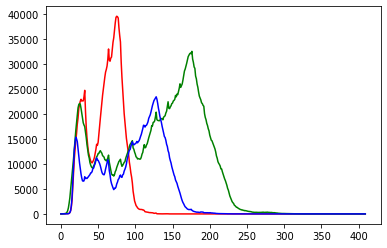

In [13]:
plot_histogram(rIm_merge, bit_length)

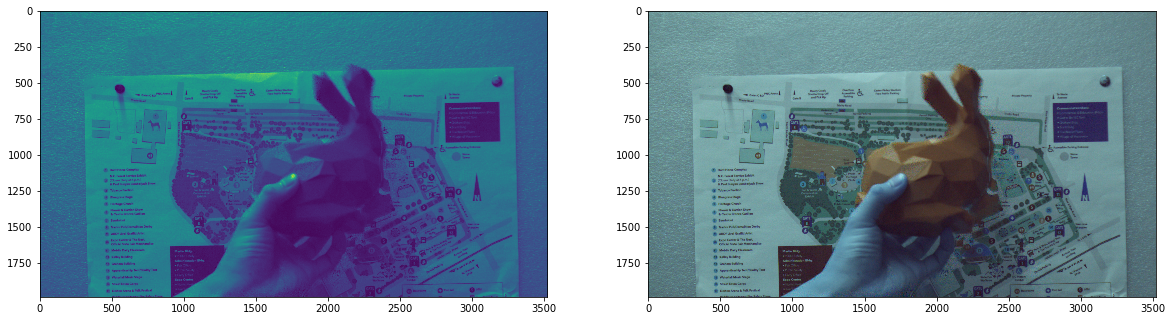

In [14]:
rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

In [15]:
import cv2
cv2.imwrite("rgbIm_adj_merge_ref{}.png".format(ref_idx), rgbIm_adj_merge[..., ::-1])
cv2.imwrite("rgbIm_adj_ref{}.png".format(ref_idx), rgbIm_adj[32:-32, 32:-32, ::-1])
cv2.imwrite("rgbIm_adj_single_ref{}.png".format(ref_idx), rgbIm_adj_single[32:-32, 32:-32, ::-1])

True

## comparison: left to right: flow+merge, summation, single

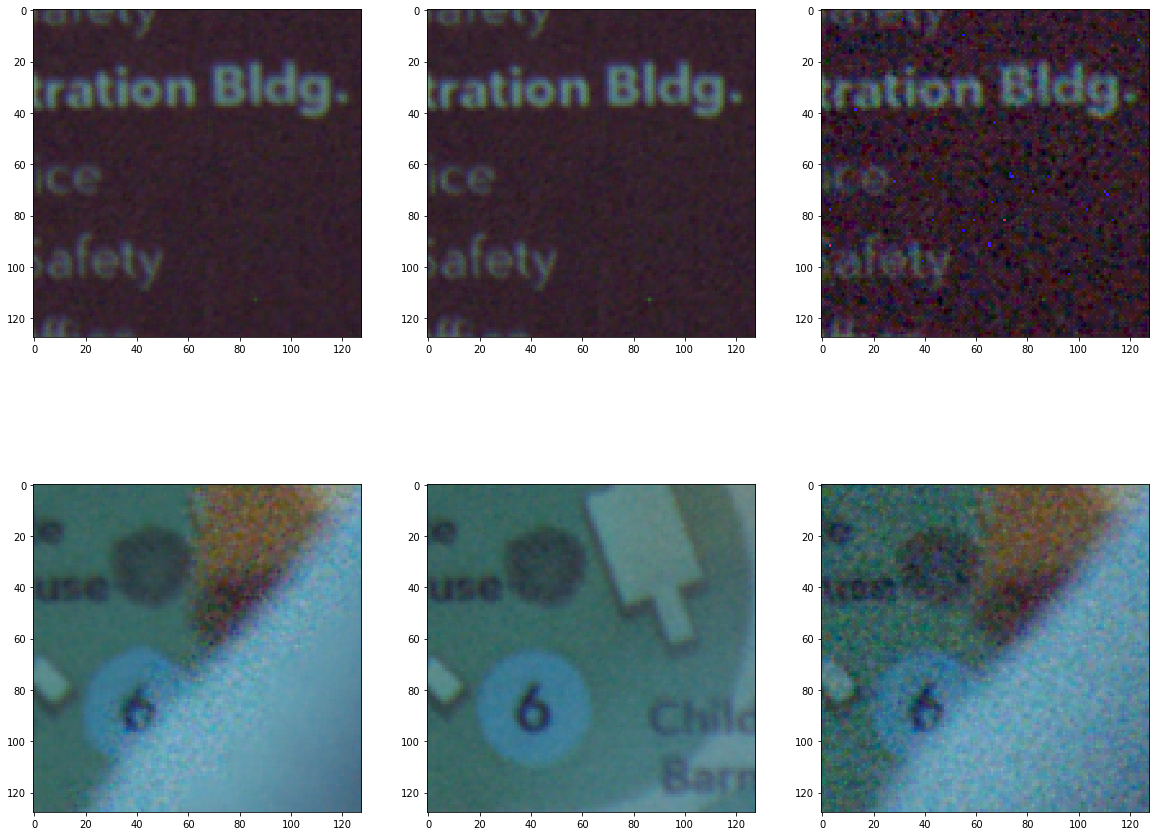

In [16]:
rgbIm_adj = cv2.imread("rgbIm_adj_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_single = cv2.imread("rgbIm_adj_single_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_merge = cv2.imread("rgbIm_adj_merge_ref{}.png".format(ref_idx))[..., ::-1]

fig, ax = plt.subplots(2, 3, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[1700:1828, 1020:1148])
ax[0][1].imshow(rgbIm_adj[1700:1828, 1020:1148])
ax[0][2].imshow(rgbIm_adj_single[1700:1828, 1020:1148])
ax[1][0].imshow(rgbIm_adj_merge[1300:1300+128, 1500-128:1500])
ax[1][1].imshow(rgbIm_adj[1300:1300+128, 1500-128:1500])
ax[1][2].imshow(rgbIm_adj_single[1300:1300+128, 1500-128:1500])
plt.show()

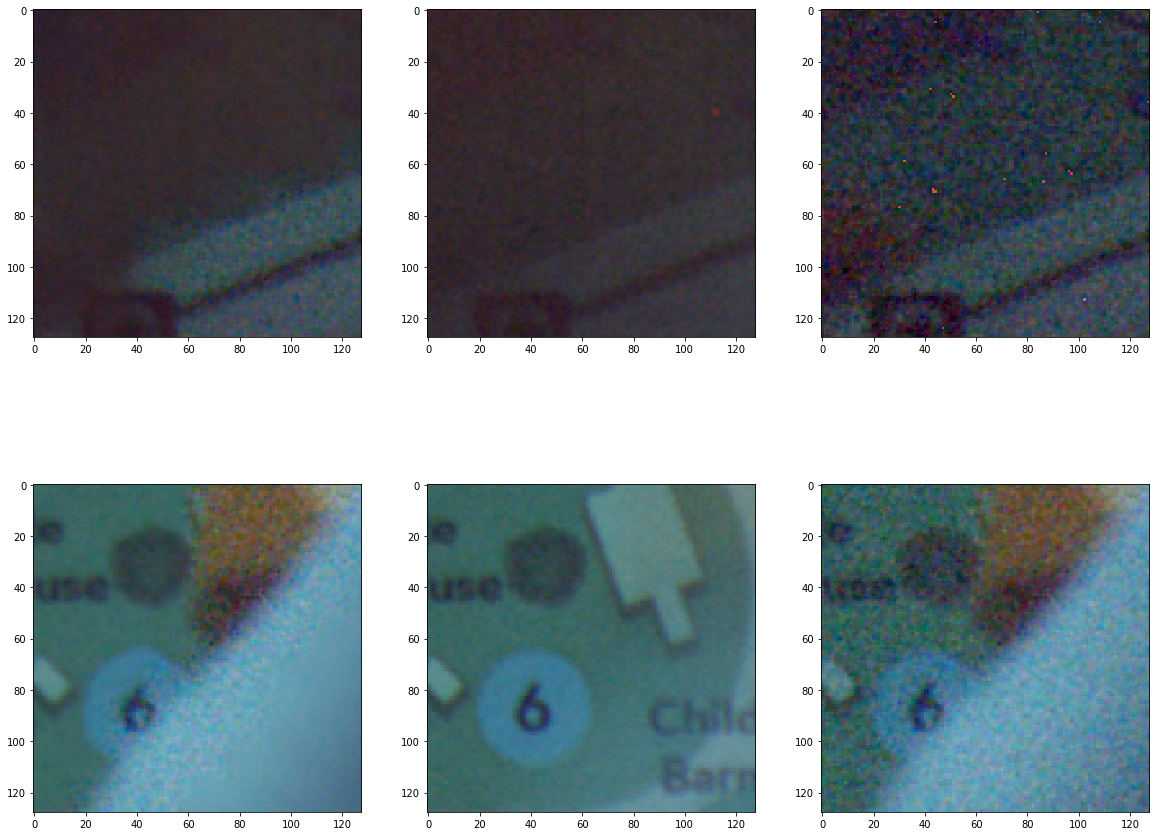

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[1350:1350+128, 2400-128:2400])
ax[0][1].imshow(rgbIm_adj[1350:1350+128, 2400-128:2400])
ax[0][2].imshow(rgbIm_adj_single[1350:1350+128, 2400-128:2400])
ax[1][0].imshow(rgbIm_adj_merge[1300:1300+128, 1500-128:1500])
ax[1][1].imshow(rgbIm_adj[1300:1300+128, 1500-128:1500])
ax[1][2].imshow(rgbIm_adj_single[1300:1300+128, 1500-128:1500])
plt.show()

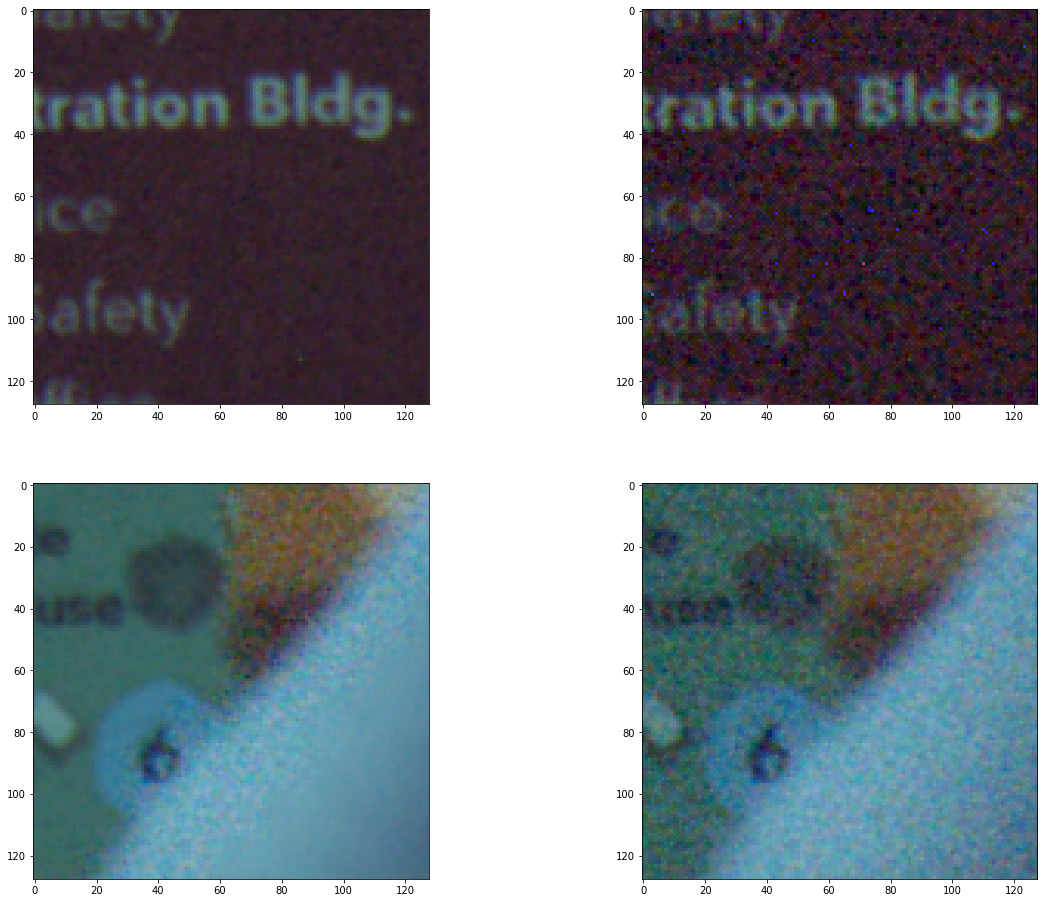

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
ref_idx = 0
rgbIm_adj = cv2.imread("rgbIm_adj_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_single = cv2.imread("rgbIm_adj_single_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_merge = cv2.imread("rgbIm_adj_merge_ref{}.png".format(ref_idx))[..., ::-1]

fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[1700:1828, 1020:1148])
ax[0][1].imshow(rgbIm_adj_single[1700:1828, 1020:1148])
ax[1][0].imshow(rgbIm_adj_merge[1300:1300+128, 1500-128:1500])
ax[1][1].imshow(rgbIm_adj_single[1300:1300+128, 1500-128:1500])
plt.show()